# **1. Read & Merge All Datasets**

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install streamlit pyngrok --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.5 MB/s eta 0:00:00


# **2. Count Number of Rows**

In [ ]:
import pandas as pd
import glob

# Path to your dataset folder in Drive
folder_path = '/content/drive/My Drive/tokenlaunch_dataset/'

# Read all Excel files matching the naming pattern
all_files = glob.glob(folder_path + "token_dataset_*.xlsx")

# Concatenate all into one DataFrame
df = pd.concat([pd.read_excel(file) for file in all_files], ignore_index=True)

# Preview the data
df.head()


,Token Contract Address,Token Bonded Timestamp (UTC),1 min Volume,Unique Holders in 1 min,Top 10% Holder Share,Clustered Wallet Indicator,30 min Market Cap,Rugged Label
0,a629308019f6d66eaae3b8742313e624a66f2c58pump,00:00:00,100249,470,0.78,0,26570,0
1,4d8256ad502547f08b3fec325c47cc0d1fbf6914pump,00:02:00,26599,1204,0.47,1,42531,0
2,07be7935a7c9a9953af96fc67f64bc6b1f58de6epump,00:04:00,35720,758,0.24,0,33596,0
3,82b81fb056f3ea4493f8a3527c51d8726c1ca58bpump,00:06:00,23425,1393,0.42,1,36781,0
4,f47e86d4d58b88641e4b5bf37eb3b49dd6615ea2pump,00:06:00,118884,755,0.87,0,43615,0


# **3. Check for Missing Data**


In [ ]:
print("Total number of rows:", len(df))


Total number of rows: 41000


In [ ]:
missing_data = df.isnull().sum()
print("Missing data per column:\n", missing_data)


Missing data per column:
 Token Contract Address          0
Token Bonded Timestamp (UTC)    0
1 min Volume                    0
Unique Holders in 1 min         0
Top 10% Holder Share            0
Clustered Wallet Indicator      0
30 min Market Cap               0
Rugged Label                    0
dtype: int64


# **4. Removing Outliers**

In [ ]:
def remove_outliers_iqr(dataframe, columns):
    df_clean = dataframe.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Define columns to filter
numeric_cols = ['1 min Volume', 'Unique Holders in 1 min', 'Top 10% Holder Share', '30 min Market Cap']
df = remove_outliers_iqr(df, numeric_cols)

print("Data shape after outlier removal:", df.shape)


Data shape after outlier removal: (37518, 8)


In [ ]:
# Check for 0s or invalid patterns
print("Tokens with 0 unique holders:", df[df['Unique Holders in 1 min'] == 0].shape)
print("Tokens with 0 volume:", df[df['1 min Volume'] == 0].shape)


Tokens with 0 unique holders: (0, 8)
Tokens with 0 volume: (0, 8)


# **5. Preprocess the Data**

Market Cap as Target

In [ ]:
import pandas as pd

# 1. Load again (if needed)
# df = pd.read_excel("/content/drive/My Drive/tokenlaunch_dataset/token_dataset_merged.xlsx")

# 2. Convert 'Token Bonded Timestamp (UTC)' to datetime safely
df['Parsed Timestamp'] = pd.to_datetime(
    df['Token Bonded Timestamp (UTC)'].astype(str),
    format='%H:%M:%S',
    errors='coerce'  # Converts invalid formats to NaT
)

# 3. Drop rows where timestamp couldn't be parsed
df = df.dropna(subset=['Parsed Timestamp'])

# 4. Convert parsed datetime to minutes since midnight
df['Bonded Time (Minutes Since Midnight UTC)'] = df['Parsed Timestamp'].dt.hour * 60 + df['Parsed Timestamp'].dt.minute

# 5. Drop the old timestamp columns
df = df.drop(columns=['Token Bonded Timestamp (UTC)', 'Parsed Timestamp'])

# Drop token contract address (not useful for prediction)
df = df.drop(columns=['Token Contract Address'])

# 6. Save the cleaned dataset
output_path = "/content/drive/My Drive/tokenlaunch_dataset/token_dataset_merged_cleaned_with_risk.xlsx"
df.to_excel(output_path, index=False)

print("✅ Final cleaned dataset saved to:")
print(output_path)




<ipython-input-9-d71ac7e12ff7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bonded Time (Minutes Since Midnight UTC)'] = df['Parsed Timestamp'].dt.hour * 60 + df['Parsed Timestamp'].dt.minute


✅ Final cleaned dataset saved to:
/content/drive/My Drive/tokenlaunch_dataset/synthetic_token_dataset_merged_cleaned.xlsx


In [ ]:
# Function to assign Risk Label
def assign_risk_label(market_cap):
    if market_cap <= 20000:
        return 0  # Rugged
    elif 20000 < market_cap <= 60000:
        return 1  # Cautious
    else:
        return 2  # Safe

# Apply the function
df['Risk_Label'] = df['30 min Market Cap'].apply(assign_risk_label)

# Add human-readable version (optional)
risk_label_map = {0: 'Rugged', 1: 'Cautious', 2: 'Safe'}
df['Risk_Description'] = df['Risk_Label'].map(risk_label_map)

# Show the result
print(df[['30 min Market Cap', 'Risk_Label', 'Risk_Description']])

# Variables That Indicate A Token Is Likely to Be Fraudulent

In [4]:
import pandas as pd

# Load the dataset
file_path = "/content/drive/My Drive/tokenlaunch_dataset/token_dataset_merged_cleaned_with_risk.xlsx"
df = pd.read_excel(file_path)

# Filter for tokens with Top 10% Holder Share >= 0.7 AND Risk Label == 'Rugged'
filtered = df[(df['Top 10% Holder Share'] >= 0.10) & (df['Risk Label'] == 'Rugged')]

# Count of those cases
rugged_high_concentration_count = len(filtered)

# Total number of tokens (you can also use df.drop_duplicates() if duplicates are present)
total_tokens = len(df)

# Percentage of total
percentage = (rugged_high_concentration_count / total_tokens) * 100

# Output the result
print(f"Number of 'Rugged' tokens with Top 10% Holder Share >= 0.7: {rugged_high_concentration_count}")
print(f"Percentage of total tokens: {percentage:.2f}%")


Number of 'Rugged' tokens with Top 10% Holder Share >= 0.7: 12622
Percentage of total tokens: 36.33%


In [11]:
import pandas as pd

# Load the dataset
file_path = "/content/drive/My Drive/tokenlaunch_dataset/token_dataset_merged_cleaned_with_risk.xlsx"
df = pd.read_excel(file_path)

# Step 1: Filter all Rugged tokens
rugged_tokens = df[df['Risk Label'] == 'Rugged']

# Step 2: From Rugged tokens, filter those with Top 10% Holder Share >= 0.7
rugged_high_concentration = rugged_tokens[rugged_tokens['Top 10% Holder Share'] >= 0.4]

# Step 3: Count and calculate percentage
count_rugged_high_concentration = len(rugged_high_concentration)
total_rugged = len(rugged_tokens)
percentage = (count_rugged_high_concentration / total_rugged) * 100 if total_rugged > 0 else 0

# Output
print(f"Rugged tokens with Top 10% Holder Share ≥ 0.4: {count_rugged_high_concentration}")
print(f"Total Rugged tokens: {total_rugged}")
print(f"Percentage of Rugged tokens with high holder concentration: {percentage:.2f}%")


Rugged tokens with Top 10% Holder Share ≥ 0.4: 9320
Total Rugged tokens: 12622
Percentage of Rugged tokens with high holder concentration: 73.84%


In [14]:
import pandas as pd

# Load the dataset
file_path = "/content/drive/My Drive/tokenlaunch_dataset/token_dataset_merged_cleaned_with_risk.xlsx"
df = pd.read_excel(file_path)

# Define bins and labels for the Top 10% Holder Share distribution
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0–20%', '>20–40%', '>40–60%', '>60–80%', '>80–100%']

# Create a new column with binned categories
df['Holder_Share_Bin'] = pd.cut(df['Top 10% Holder Share'], bins=bins, labels=labels, include_lowest=True)

# Count frequency and percentage of each bin
distribution = df['Holder_Share_Bin'].value_counts(sort=False).reset_index()
distribution.columns = ['Holder Share Range', 'Token Count']
distribution['Percentage'] = (distribution['Token Count'] / len(df)) * 100

# Display the result
print(distribution)


  Holder Share Range  Token Count  Percentage
0              0–20%          244    0.702239
1            >20–40%         9403   27.062108
2            >40–60%         9127   26.267772
3            >60–80%         9269   26.676452
4           >80–100%         6703   19.291429


In [20]:
import pandas as pd

# Load the dataset
file_path = "/content/drive/My Drive/tokenlaunch_dataset/token_dataset_merged_cleaned_with_risk.xlsx"
df = pd.read_excel(file_path)

# Step 1: Filter all Rugged tokens
rugged_tokens = df[df['Risk Label'] == 'Rugged']

# Step 2: From Rugged tokens, filter those with 1 min Volume >= 100000
rugged_high_volume = rugged_tokens[rugged_tokens['1 min Volume'] <= 100000]

# Step 3: Count and calculate percentage
count_rugged_high_volume = len(rugged_high_volume)
total_rugged = len(rugged_tokens)
percentage = (count_rugged_high_volume / total_rugged) * 100 if total_rugged > 0 else 0

# Output
print(f"Rugged tokens with 1 min Volume <= 100,000: {count_rugged_high_volume}")
print(f"Total Rugged tokens: {total_rugged}")
print(f"Percentage of Rugged tokens with 1 min volume lower than 100,000 usd : {percentage:.2f}%")


Rugged tokens with 1 min Volume <= 100,000: 9397
Total Rugged tokens: 12622
Percentage of Rugged tokens with 1 min volume lower than 100,000 usd : 74.45%


In [29]:
import pandas as pd

# Load the dataset
file_path = "/content/drive/My Drive/tokenlaunch_dataset/token_dataset_merged_cleaned_with_risk.xlsx"
df = pd.read_excel(file_path)

# Step 1: Filter Safe tokens
safe_tokens = df[df['Risk Label'] == 'Safe'].copy()

# Step 2: Define 8-hour time intervals
def classify_8hr_block(minutes):
    if 0 <= minutes < 480:
        return "00:00–08:00 UTC"
    elif 480 <= minutes < 960:
        return "08:00–16:00 UTC"
    elif 960 <= minutes < 1440:
        return "16:00–00:00 UTC"
    else:
        return "Invalid"

# Step 3: Apply classification
safe_tokens['8hr Time Block'] = safe_tokens['Bonded Time (Minutes Since Midnight UTC)'].apply(classify_8hr_block)

# Step 4: Count number of Safe tokens in each block
safe_counts_8hr = safe_tokens['8hr Time Block'].value_counts().reset_index()
safe_counts_8hr.columns = ['8hr Time Block', 'Safe Token Count']
safe_counts_8hr = safe_counts_8hr.sort_values(by='Safe Token Count', ascending=False)

# Output
print(safe_counts_8hr)


    8hr Time Block  Safe Token Count
0  08:00–16:00 UTC                43
1  16:00–00:00 UTC                32
2  00:00–08:00 UTC                27


In [30]:
import pandas as pd

# Load the dataset
file_path = "/content/drive/My Drive/tokenlaunch_dataset/token_dataset_merged_cleaned_with_risk.xlsx"
df = pd.read_excel(file_path)

# Step 1: Filter Safe tokens
safe_tokens = df[df['Risk Label'] == 'Safe'].copy()

# Step 2: Define 8-hour time intervals
def classify_8hr_block(minutes):
    if 0 <= minutes < 480:
        return "00:00–08:00 UTC"
    elif 480 <= minutes < 960:
        return "08:00–16:00 UTC"
    elif 960 <= minutes < 1440:
        return "16:00–00:00 UTC"
    else:
        return "Invalid"

# Step 3: Apply classification
safe_tokens['8hr Time Block'] = safe_tokens['Bonded Time (Minutes Since Midnight UTC)'].apply(classify_8hr_block)

# Step 4: Count number of Safe tokens in each block and calculate percentage
safe_counts_8hr = safe_tokens['8hr Time Block'].value_counts().reset_index()
safe_counts_8hr.columns = ['8hr Time Block', 'Safe Token Count']
total_safe = len(safe_tokens)
safe_counts_8hr['Percentage of Safe Tokens'] = (safe_counts_8hr['Safe Token Count'] / total_safe) * 100

# Step 5: Sort by count descending
safe_counts_8hr = safe_counts_8hr.sort_values(by='Safe Token Count', ascending=False)

# Output
print(safe_counts_8hr)


    8hr Time Block  Safe Token Count  Percentage of Safe Tokens
0  08:00–16:00 UTC                43                  42.156863
1  16:00–00:00 UTC                32                  31.372549
2  00:00–08:00 UTC                27                  26.470588


In [36]:
import pandas as pd

# Load the dataset
file_path = "/content/drive/My Drive/tokenlaunch_dataset/token_dataset_merged_cleaned_with_risk.xlsx"
df = pd.read_excel(file_path)

# Step 1: Filter all Rugged tokens
rugged_tokens = df[df['Risk Label'] == 'Rugged'].copy()

# Step 2: Filter Rugged tokens with 50–300 unique holders in the first minute
rugged_50_to_300_holders = rugged_tokens[
    (rugged_tokens['Unique Holders in 1 min'] >= 1000) &
    (rugged_tokens['Unique Holders in 1 min'] <= 2000)
]

# Step 3: Count and calculate percentage
count_rugged_50_to_300 = len(rugged_50_to_300_holders)
total_rugged = len(rugged_tokens)
percentage = (count_rugged_50_to_300 / total_rugged) * 100 if total_rugged > 0 else 0

# Output
print(f"Rugged tokens with >= 1000 unique holders in 1 min: {count_rugged_50_to_300}")
print(f"Total Rugged tokens: {total_rugged}")
print(f"Percentage of Rugged tokens in this range: {percentage:.2f}%")


Rugged tokens with >= 1000 unique holders in 1 min: 4278
Total Rugged tokens: 12622
Percentage of Rugged tokens in this range: 33.89%


In [35]:
import pandas as pd

# Load the dataset
file_path = "/content/drive/My Drive/tokenlaunch_dataset/token_dataset_merged_cleaned_with_risk.xlsx"
df = pd.read_excel(file_path)

# Step 1: Filter only Rugged tokens
rugged_tokens = df[df['Risk Label'] == 'Rugged'].copy()

# Step 2: Define bins and labels
bins = [49, 300, 600, 900, 1200, 1499]
labels = ['50–300', '301–600', '601–900', '901–1200', '1201–1499']

# Step 3: Create a binned column
rugged_tokens['Holder Range'] = pd.cut(rugged_tokens['Unique Holders in 1 min'], bins=bins, labels=labels)

# Step 4: Count frequency and calculate percentage
holder_distribution = rugged_tokens['Holder Range'].value_counts(sort=False).reset_index()
holder_distribution.columns = ['Holder Range', 'Rugged Token Count']
total_rugged = len(rugged_tokens)
holder_distribution['Percentage of Rugged Tokens'] = (holder_distribution['Rugged Token Count'] / total_rugged) * 100

# Step 5: Display result
print(holder_distribution)


  Holder Range  Rugged Token Count  Percentage of Rugged Tokens
0       50–300                2199                    17.421962
1      301–600                2605                    20.638568
2      601–900                2661                    21.082237
3     901–1200                2571                    20.369197
4    1201–1499                2586                    20.488037


# **6. Train/Test Split**

In [ ]:
!pip install lightgbm catboost shap --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.5 MB/s eta 0:00:00



# **7. Explain Best Model with SHAP**

Market Cap as Target

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4146, number of negative: 23650
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 27796, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.149158 -> initscore=-1.741219
[LightGBM] [Info] Start training from score -1.741219


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


<Figure size 640x480 with 0 Axes>

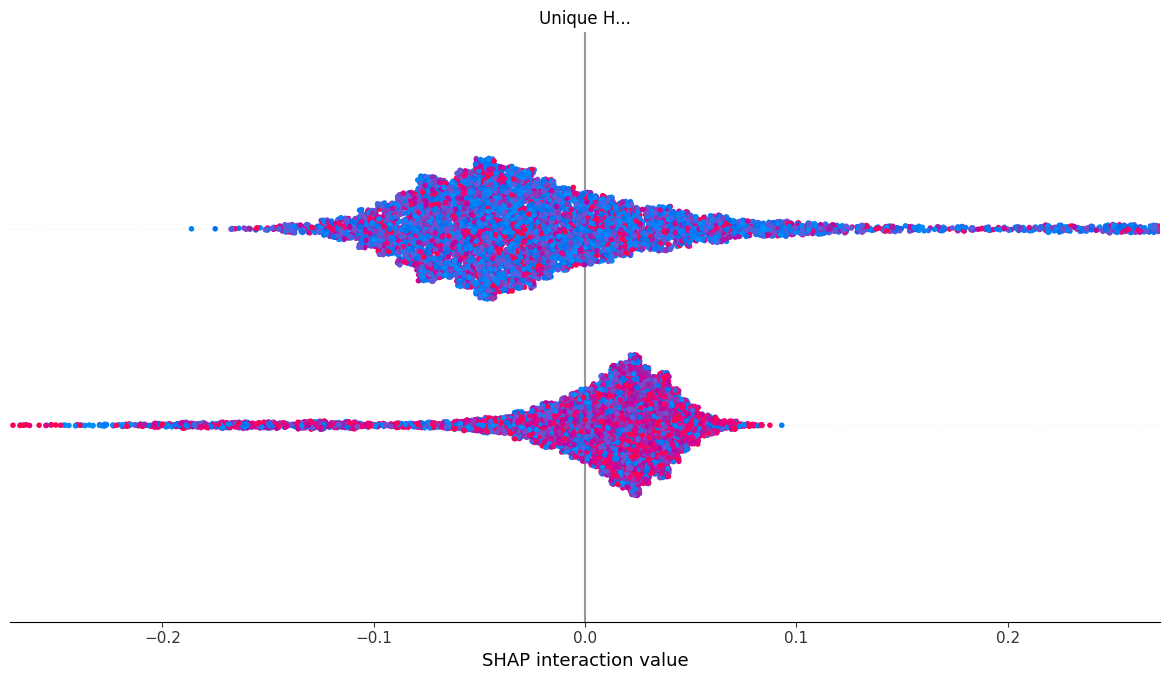

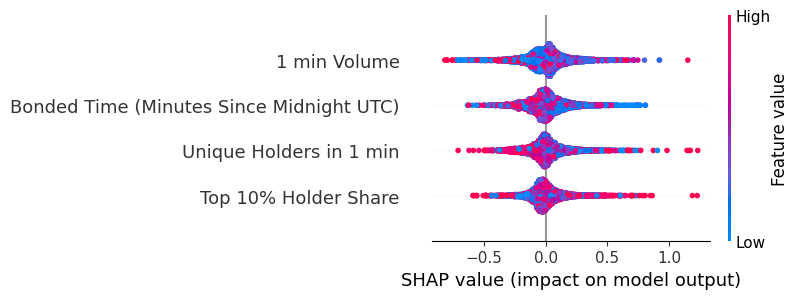

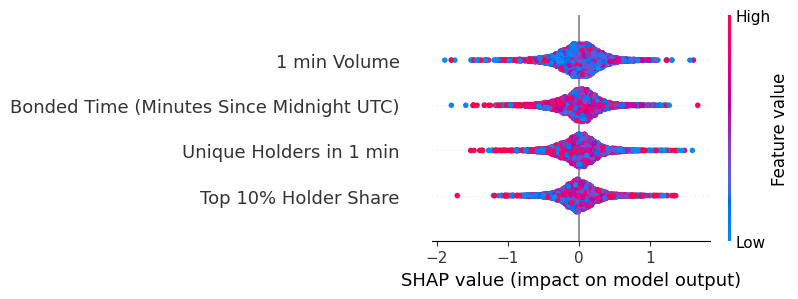

Model Evaluation Results:
Random Forest Accuracy: 0.9317, AUC: 0.8767
LightGBM Accuracy: 0.8563, AUC: 0.6989
CatBoost Accuracy: 0.8678, AUC: 0.7509


In [ ]:
# 1. Feature Engineering: Define target and features
# Token is 'rugged' if 30-minute market cap is below 10,000
df['Rugged'] = (df['30 min Market Cap'] < 10000).astype(int)

# Add 'Minutes Since Bonded' to the features
features = ['Unique Holders in 1 min', '1 min Volume', 'Top 10% Holder Share', 'Bonded Time (Minutes Since Midnight UTC)']
X = df[features]
y = df['Rugged']

# 2. Split the data into training and test sets (80/20 split)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model Building: Random Forest, LightGBM, and CatBoost
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Train LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Train CatBoost
catboost_model = CatBoostClassifier(learning_rate=0.1, iterations=1000, depth=6, random_state=42, silent=True)
catboost_model.fit(X_train, y_train)

# 4. SHAP Evaluation: Analyze feature importance using SHAP

import shap

# Use SHAP to explain Random Forest model
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# Use SHAP to explain LightGBM model
explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Use SHAP to explain CatBoost model
explainer_catboost = shap.TreeExplainer(catboost_model)
shap_values_catboost = explainer_catboost.shap_values(X_test)

# Plot SHAP values for Random Forest
shap.summary_plot(shap_values_rf, X_test)

# Plot SHAP values for LightGBM
shap.summary_plot(shap_values_lgb, X_test)

# Plot SHAP values for CatBoost
shap.summary_plot(shap_values_catboost, X_test)

# Evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# Predict and evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_prob_rf)

# Predict and evaluate LightGBM
y_pred_lgb = lgb_model.predict(X_test)
y_pred_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]

accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
roc_auc_lgb = roc_auc_score(y_test, y_pred_prob_lgb)

# Predict and evaluate CatBoost
y_pred_catboost = catboost_model.predict(X_test)
y_pred_prob_catboost = catboost_model.predict_proba(X_test)[:, 1]

accuracy_catboost = accuracy_score(y_test, y_pred_catboost)
roc_auc_catboost = roc_auc_score(y_test, y_pred_prob_catboost)

print("Model Evaluation Results:")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}, AUC: {roc_auc_rf:.4f}")
print(f"LightGBM Accuracy: {accuracy_lgb:.4f}, AUC: {roc_auc_lgb:.4f}")
print(f"CatBoost Accuracy: {accuracy_catboost:.4f}, AUC: {roc_auc_catboost:.4f}")


Risk Category as Target

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 842
[LightGBM] [Info] Number of data points in the train set: 27796, number of used features: 4
[LightGBM] [Info] Start training from score -1.012654
[LightGBM] [Info] Start training from score -0.456028
[LightGBM] [Info] Start training from score -5.825928


<Figure size 640x480 with 0 Axes>

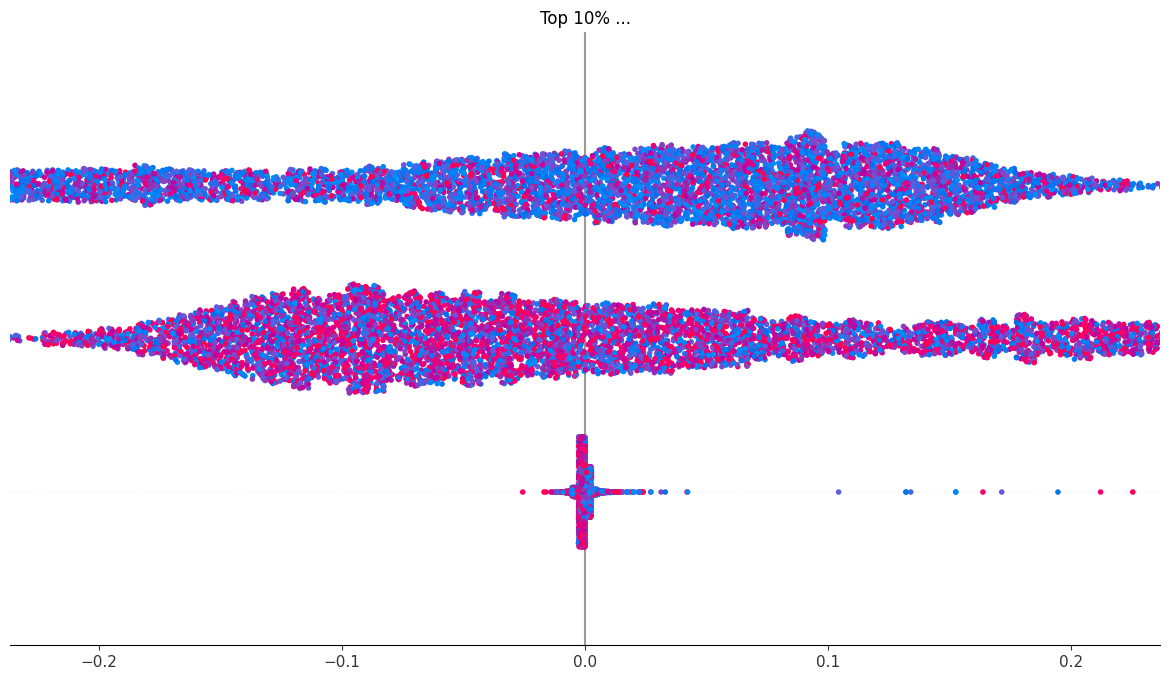

<Figure size 640x480 with 0 Axes>

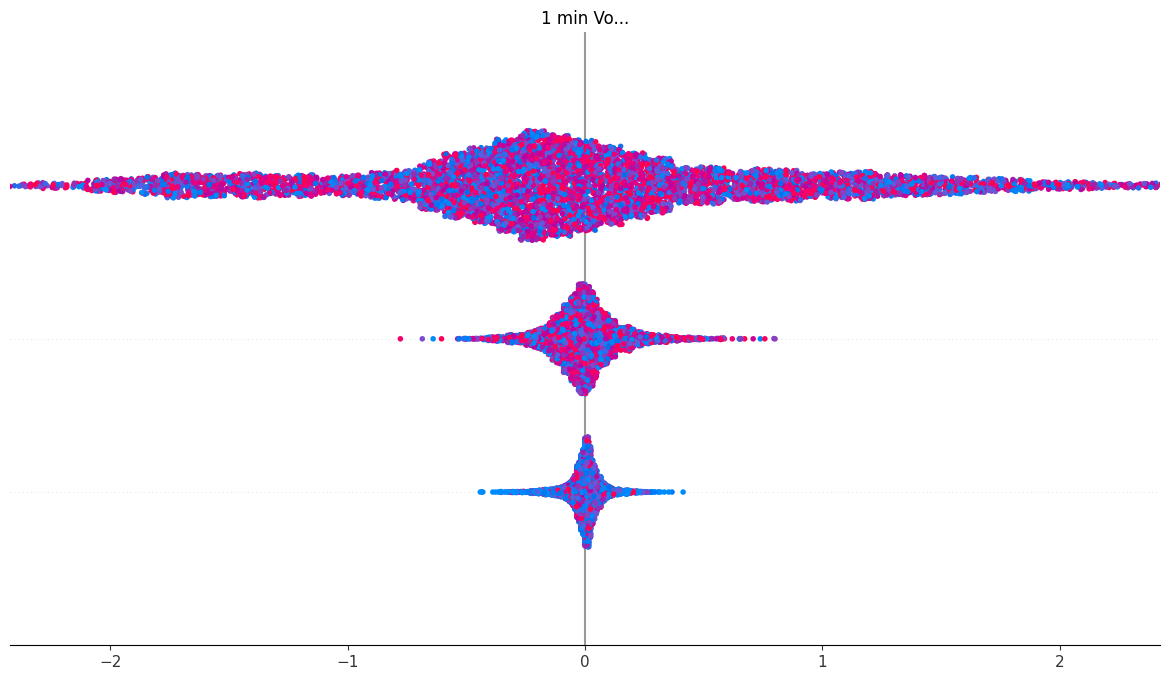

<Figure size 640x480 with 0 Axes>

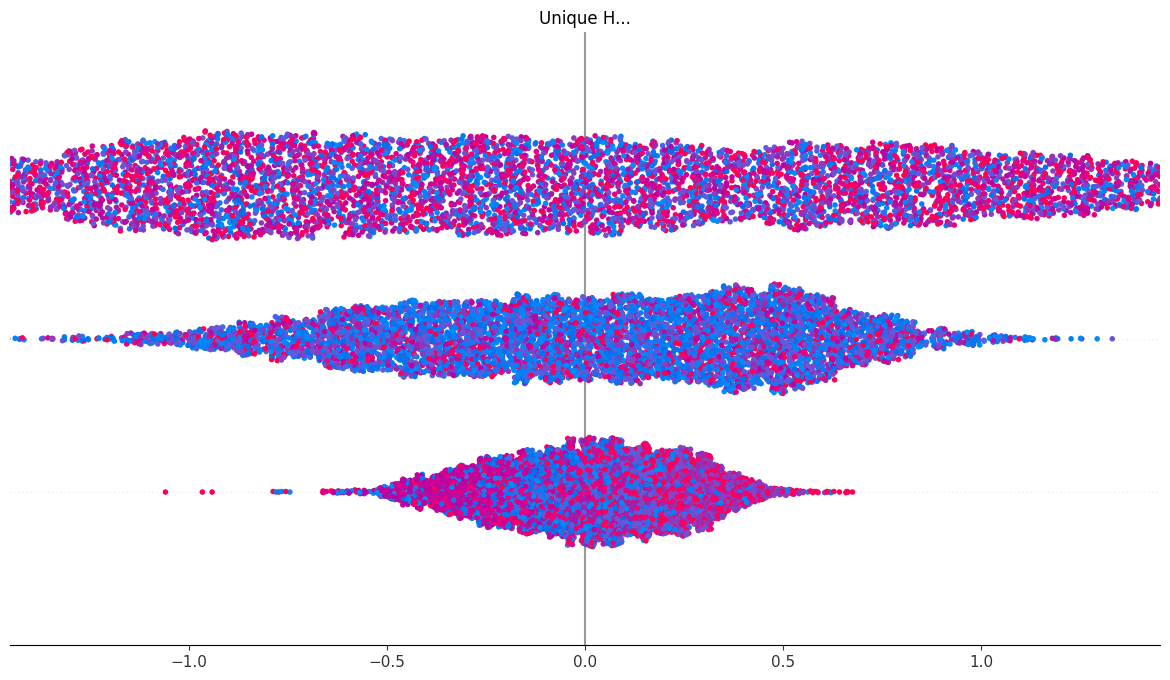

Model Evaluation Results:

Random Forest:
              precision    recall  f1-score   support

      Rugged       0.81      0.63      0.71      2525
    Cautious       0.81      0.92      0.86      4405
        Safe       1.00      0.60      0.75        20

    accuracy                           0.81      6950
   macro avg       0.88      0.72      0.77      6950
weighted avg       0.81      0.81      0.81      6950


LightGBM:
              precision    recall  f1-score   support

      Rugged       0.69      0.11      0.19      2525
    Cautious       0.65      0.97      0.78      4405
        Safe       1.00      0.60      0.75        20

    accuracy                           0.66      6950
   macro avg       0.78      0.56      0.57      6950
weighted avg       0.67      0.66      0.57      6950


CatBoost:
              precision    recall  f1-score   support

      Rugged       0.66      0.18      0.28      2525
    Cautious       0.67      0.95      0.78      4405
        Saf

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap

# 1. Feature Engineering: Define target and features
# Assumes 'Risk Category' already exists (0 = Rugged, 1 = Cautious, 2 = Safe)
features = ['Unique Holders in 1 min', '1 min Volume', 'Top 10% Holder Share', 'Bonded Time (Minutes Since Midnight UTC)']
X = df[features]
y = df['Risk Category']

# 2. Split the data into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 4. Train LightGBM
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=3, random_state=42)
lgb_model.fit(X_train, y_train)

# 5. Train CatBoost
catboost_model = CatBoostClassifier(learning_rate=0.1, iterations=1000, depth=6,
                                    random_state=42, silent=True, loss_function='MultiClass')
catboost_model.fit(X_train, y_train)

# 6. SHAP Analysis
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)
shap.summary_plot(shap_values_rf, X_test)

explainer_lgb = shap.TreeExplainer(lgb_model)
shap_values_lgb = explainer_lgb.shap_values(X_test)
shap.summary_plot(shap_values_lgb, X_test)

explainer_catboost = shap.TreeExplainer(catboost_model)
shap_values_catboost = explainer_catboost.shap_values(X_test)
shap.summary_plot(shap_values_catboost, X_test)

# 7. Evaluate Models
print("Model Evaluation Results:")

# Random Forest
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['Rugged', 'Cautious', 'Safe']))

# LightGBM
y_pred_lgb = lgb_model.predict(X_test)
print("\nLightGBM:")
print(classification_report(y_test, y_pred_lgb, target_names=['Rugged', 'Cautious', 'Safe']))

# CatBoost
y_pred_catboost = catboost_model.predict(X_test)
print("\nCatBoost:")
print(classification_report(y_test, y_pred_catboost, target_names=['Rugged', 'Cautious', 'Safe']))


# **8. Understanding How The Model Made Predictions In General**

Random Forest Regression MAE: 7198.0632, MSE: 100047424.6002, R²: 0.4652
Random Forest Feature Importance:
                                    Feature  Mean SHAP Value
1                              1 min Volume      2017.747757
0                   Unique Holders in 1 min      1673.685286
3  Bonded Time (Minutes Since Midnight UTC)      1594.262450
2                      Top 10% Holder Share      1359.278756


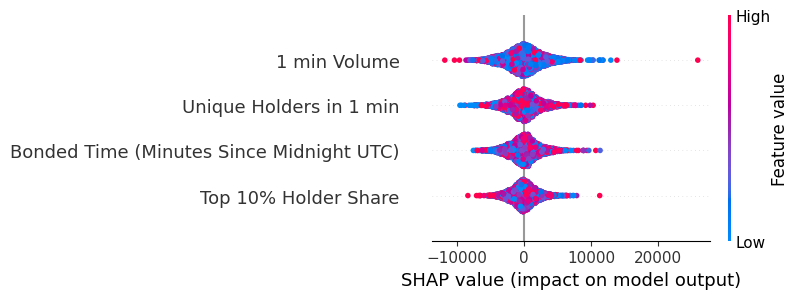

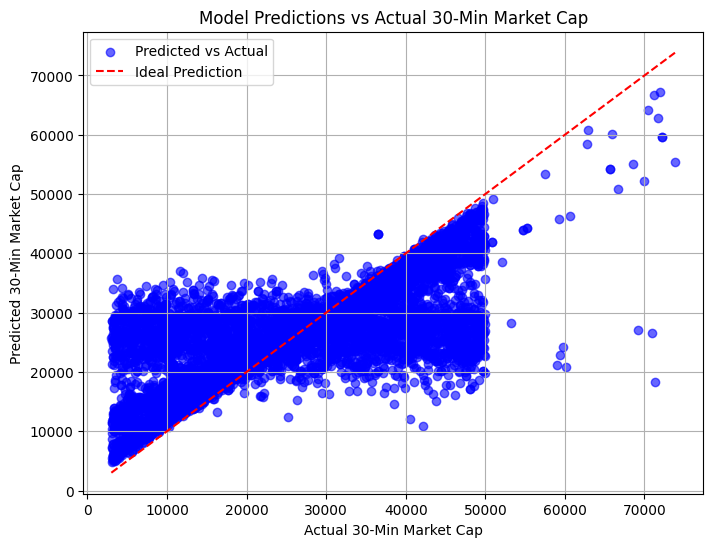

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Feature Engineering: Define target as 30-minute market cap
df['Target'] = df['30 min Market Cap']  # Use 30 min Market Cap as the target

# Define the features including 'Bonded Time (Minutes Since Midnight UTC)'
features = ['Unique Holders in 1 min', '1 min Volume', 'Top 10% Holder Share', 'Bonded Time (Minutes Since Midnight UTC)']
X = df[features]
y = df['Target']  # Target is the 30-minute market cap

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model using regression metrics
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regression MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

# SHAP Feature Importance Insights for Regression

# Create SHAP explainer and compute SHAP values
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# Since we're doing regression, there's no need to differentiate classes, so use shap_values_rf directly
mean_shap_values_rf = np.abs(shap_values_rf).mean(axis=0)  # Mean absolute SHAP values across samples

# Create a DataFrame to display feature importance
feature_importance_df_rf = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean SHAP Value': mean_shap_values_rf
})

# Sort by SHAP value
feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Mean SHAP Value', ascending=False)

# Display the feature importance directly in the console
print("Random Forest Feature Importance:")
print(feature_importance_df_rf)

# SHAP summary plot
shap.summary_plot(shap_values_rf, X_test)

# Visualization: Model Predictions vs Actual

# Create the scatter plot of predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Model Predictions vs Actual 30-Min Market Cap')
plt.xlabel('Actual 30-Min Market Cap')
plt.ylabel('Predicted 30-Min Market Cap')
plt.legend()
plt.grid(True)
plt.show()


Risk Category as Target

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


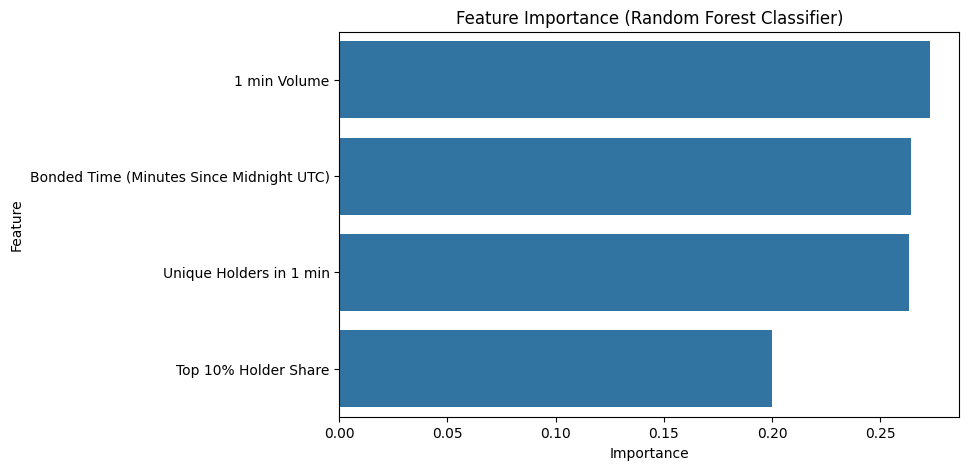

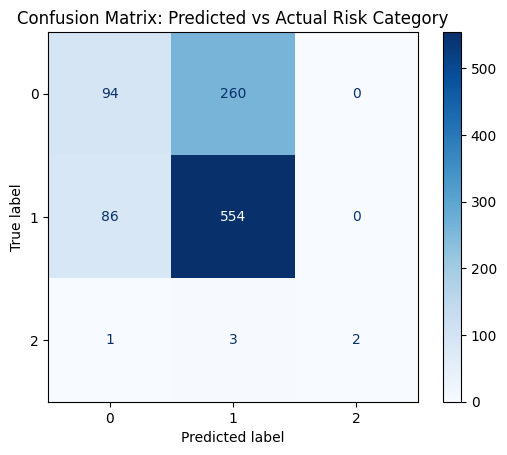


Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.27      0.35       354
           1       0.68      0.87      0.76       640
           2       1.00      0.33      0.50         6

    accuracy                           0.65      1000
   macro avg       0.73      0.49      0.54      1000
weighted avg       0.62      0.65      0.61      1000


SHAP skipped due to: The shape of the shap_values matrix does not match the shape of the provided data matrix.
✅ Model saved to: /content/drive/My Drive/rf_risk_model.pkl


<Figure size 640x480 with 0 Axes>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
import pandas as pd

file_path = "/content/drive/My Drive/tokenlaunch_dataset/dataset_merged_cleaned_with_risk.xlsx"
df = pd.read_excel(file_path)

# Optional: Downsample for memory efficiency (can increase if needed)
df = df.sample(n=5000, random_state=42)

# Define features and target
features = ['Unique Holders in 1 min', '1 min Volume', 'Top 10% Holder Share', 'Bonded Time (Minutes Since Midnight UTC)']
X = df[features]
y = df['Risk Category']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Show feature importances
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

importances = clf.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Feature Importance (Random Forest Classifier)")
plt.show()

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Predicted vs Actual Risk Category")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Optional: SHAP (only if supported)
try:
    import shap
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values[1], X_test)  # Class 1
except Exception as e:
    print(f"\nSHAP skipped due to: {e}")

import joblib

# Save the trained model to Google Drive
model_path = "/content/drive/My Drive/rf_risk_model.pkl"
joblib.dump(clf, model_path)

print(f"✅ Model saved to: {model_path}")

# **9. Understanding How The Model Made Preditctitions Individually**

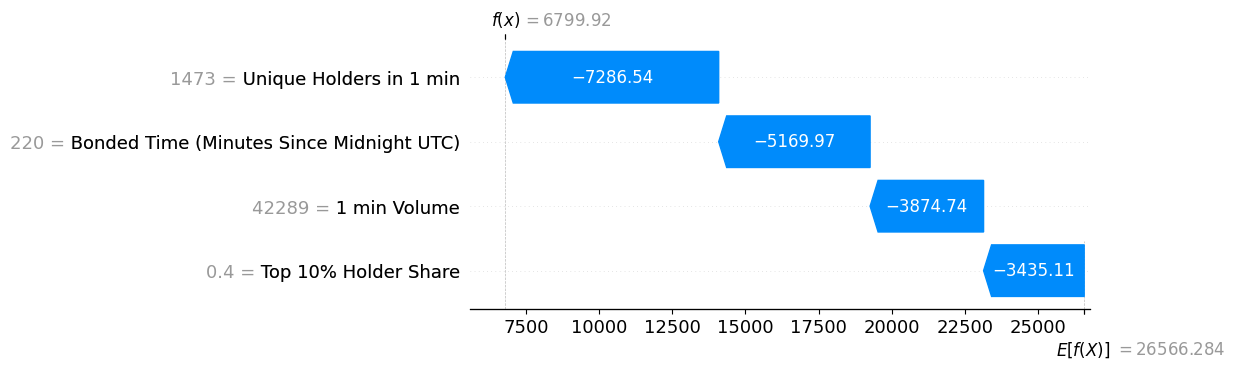

In [ ]:
import shap

# Use the RandomForest model to get SHAP values
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# Choose a sample (e.g., first sample in the test set)
sample_index = 0

# Wrap the SHAP values for the sample in an Explanation object
shap_values_instance = shap.Explanation(values=shap_values_rf[sample_index],
                                        base_values=explainer_rf.expected_value,
                                        data=X_test.iloc[sample_index])

# SHAP Waterfall Plot for the chosen instance
shap.waterfall_plot(shap_values_instance)

# **10. DASHBOARD**

In [ ]:
app_code = """
import streamlit as st
import joblib
import numpy as np
from datetime import datetime

# Load the saved Random Forest model
model = joblib.load("/content/drive/My Drive/rf_risk_model.pkl")

st.title("🚀 Token Launch Risk Category Predictor")

# User inputs
unique_holders = st.number_input("Unique Holders in 1 min", min_value=0, value=50)
volume = st.number_input("1 min Volume", min_value=0.0, value=1000.0)
top_holder_share = st.slider("Top 10% Holder Share", min_value=0.0, max_value=1.0, value=0.3)

# NEW: Input bonded time as UTC time
bonded_time_input = st.time_input("Token Bonded Time (UTC)", value=datetime.strptime("12:00", "%H:%M").time())
bonded_minutes = bonded_time_input.hour * 60 + bonded_time_input.minute

# Predict button
if st.button("Predict Risk Category"):
    input_data = np.array([[unique_holders, volume, top_holder_share, bonded_minutes]])
    pred = model.predict(input_data)[0]

    # Risk category mapping
    category_map = {0: "🟥 Rugged", 1: "🟨 Cautious", 2: "🟩 Safe"}
    st.success(f"Predicted Risk Category: **{category_map[pred]}**")
"""
with open("app.py", "w") as f:
    f.write(app_code)



In [ ]:
from pyngrok import conf

conf.get_default().auth_token = ""


In [ ]:
from pyngrok import ngrok
!pkill streamlit
!streamlit run app.py &> /dev/null &
public_url = ngrok.connect("http://localhost:8501")

print(f"🔗 Your Streamlit app is live at: {public_url}")




🔗 Your Streamlit app is live at: NgrokTunnel: "https://da3b-35-237-76-143.ngrok-free.app" -> "http://localhost:8501"
